In [1]:

## Import system library
import os
import glob

## Import Image Processing library
import cv2
import numpy as np
import skimage
from skimage import exposure
from skimage.color import rgb2gray
from scipy.ndimage import convolve, uniform_filter
from skimage.filters import gabor_kernel, unsharp_mask, threshold_otsu, gabor
from skimage.morphology import disk, closing, dilation
import torchvision.models as models
import matplotlib.pyplot as plt
%matplotlib inline

from utils.preprocess import sliding_window

## Import machine learning library
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from utils.lbp import LBP
from utils.vis import draw_bboxes
from utils.dataset import load_yolo_labels
from utils.iou import iou, calculate_boxA_percentage
from utils.intensity_transforms import histogram_matching, calculate_mean_histogram


In [2]:
## Defind dataset folders

# root_path = '/content/drive/Shareddrives/Wrist_fracture_detectiom/ML/Dataset'
root_path = 'MLDataset/crop_data'

img_train_folder = 'train'
img_test_folder = 'test'
label_folder = 'labels'
image_folder = 'images'

In [3]:
def export_features(export_path, name, feature_name, feature_list):
    """Save features to npy file

    Args:
        export_path (str): path to save the file
        name (str): file name to save
        feature_name (str): name of the feature. Ex: 'lbp', 'hog', 'gabor'
        feature_list (list/array): list of features
    """
    ## Export features to file
    save_name = f'{name}_{feature_name}.npy'
    save_path = os.path.join(export_path, save_name)
    np.save(save_path, feature_list)
    print(f'Save {feature_name} features to {save_path}')

## Histogram Matching

In [4]:
import glob

## Calculate mean histogram
image_files = glob.glob(os.path.join(root_path, image_folder, 'train/**/*.png'), recursive=True)
mean_histogram = calculate_mean_histogram(image_files)

In [9]:
### Extract mean histogram from the training dataset
np.save('mean_hist.npy', mean_histogram)

In [ ]:
## Apply histogram matching for each image
for i, image_file in enumerate(image_files):
    if i > 1:
        break
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    matched_img = histogram_matching(image, mean_histogram)
    ax, fig = plt.subplots(1, 2, figsize=(10, 5))
    fig[0].imshow(image)
    fig[1].imshow(matched_img)
    plt.show()

## Processing


In [5]:
def preprocess(image, mean_histogram=None, dilate_num=4, intensity_crop=1, outputbitdepth=8, unsharp=True):
    """
    Processes a single image by applying histogram matching, thresholding,
    multiple dilations, and closing.

    Args:
    - image_path (str/numpy): Path to the image file or numpy array of the image.
    - mean_histogram (array-like): The histogram to match. If None, don't match histogram.
    - dilate_num (int): Number of times dilation should be applied.
    - intensity_crop (int): Percentage of the image intensity to crop.
    - outputbitdepth (int): The bit depth of the output image.

    Returns:
    - final_image (ndarray): The processed image.
    """
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = rgb2gray(image)
    else:
        raise ValueError("Image must be a file path or numpy array.")
    
    if unsharp:
        image = ((unsharp_mask(image, radius=2, amount=1))*255).clip(0, 255).astype(np.uint8) # unsharp mask to enhance edges

    ## Histogram equalization
    # image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    # image = exposure.equalize_adapthist(image)
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    
    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh
    
    # Apply multiple dilations
    selem = disk(4)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)
    
    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)
    
    # Apply the mask to the original image using a bitwise AND operation
    final_image = cv2.bitwise_and(image, image, mask=np.uint8(closed_mask * 255))
    
    return final_image


In [6]:
def process_image_and_labels(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp):
    """
    Processes an image by preprocessing and loading corresponding labels.

    Args:
    image_path (str): Path to the image file.
    root_path (str): Base path for data.
    label_folder (str): Folder containing label files.
    mean_histogram (bool): Flag for histogram processing.
    intensity_crop (tuple): Intensity cropping parameters.
    outputbitdepth (int): Bit depth for image output.
    unsharp (bool): Flag for unsharp mask processing.

    Returns:
    tuple: A tuple containing the processed image and associated labels.
    """
    labels = []
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    ### Parse label
    image_name = os.path.basename(image_path)
    label_path = image_path.replace('images', 'labels').replace('.png', '.txt')
    if os.path.exists(label_path):
        labels = load_yolo_labels(label_path, img.shape, [3]) # 3 is the class index for fracture
    
    ## Segment bones
    img = preprocess(img, mean_histogram=mean_histogram, intensity_crop=intensity_crop, outputbitdepth=outputbitdepth, unsharp=unsharp)
    
    return img, labels

## Extract Features

In [7]:
def feature_extraction(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, descriptor, stepSize=128, windowSize=256):
    """
    Extract features from an image using a given descriptor.

    Args:
    - image_path (str): Path to the image file.
    - mean_histogram (array-like): The histogram to match. If None, don't match histogram.
    - intensity_crop (int): Percentage of the image intensity to crop.
    - outputbitdepth (int): The bit depth of the output image.
    - unsharp (bool): Flag for unsharp mask processing.
    - descriptor (object): The descriptor object to use for feature extraction.
    - show_grid (bool): Flag to show the grid of windows.

    Returns:
    - features (list): List of features extracted from the image.
    - labels_list (list): List of labels for each feature.
    """
    features = []
    labels_list = []
    image, labels = process_image_and_labels(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp)
    
    # feature_image = image     

    for i, (x, y, window_f) in enumerate(sliding_window(image, stepSize=stepSize, windowSize=windowSize)):
        if window_f.shape[0] != windowSize or window_f.shape[1] != windowSize:
            continue
        # ## Image histogram 
        feature_image = descriptor(window_f)     
        feature = feature_image.ravel()
        
        iou_score = 0
        class_id = 0
        for label in labels:
            c, *xyxy = label
            iou_score = calculate_boxA_percentage(xyxy, [x, y, x + windowSize, y + windowSize])
            if iou_score > 0.5:
                class_id = 1
            elif iou_score > 0.1 and iou_score < 0.5:
                class_id = -1
    
        features.append(feature)
        labels_list.append(class_id)

            
    return features, labels_list

In [8]:
windowSize = 256
stepSize = 128
# Parameters for LBP
num_points = 8  # Typically 8, 16, or 24
radius = 3       # Typical values are 1, 2, or 3
background_removal_threshold = 30 # Threshold for removing background in percentage

In [9]:
convert_grayscale = False
outputbitdepth = 8 # Set output bit depth
unsharp = True # Sharpen image
convert_grayscale = False # Convert to grayscale
equalize = True # CLAHE contrast enhancement
intensity_crop = 0.1 # Set rescale intensity crop

In [10]:
num_features = 2000
show_grid = False

### LBP and HOG

In [ ]:
### Extract LBP features and export to npy file
mode = 'test'
class_name = 'normal'
export_path_fracture = os.path.join(root_path, f'{mode}_{class_name}_lbp.npy')
export_path_non_fracture = os.path.join(root_path, f'{mode}_non_{class_name}_lbp.npy')
export_path_normal = os.path.join(root_path, f'{mode}_normal_lbp.npy')

fracture_features = []
non_fracture_features = []

### Local Binary Pattern
lbp = LBP(num_points, radius)
### Histogram of Oriented Gradients
hog = cv2.HOGDescriptor()
        

### Loop through all images
for idx, image_path in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))):
    print(f"Processing {image_path}")
    if len(fracture_features) >= num_features and len(non_fracture_features) >= num_features:
        break
    
    ### Extract LBP features
    image, labels = process_image_and_labels(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, fracture=True if class_name == 'fracture' else False)
    
    # Use sliding window to generate windows
    windows = list(sliding_window(image, stepSize=stepSize, windowSize=windowSize))
    num_windows = len(windows)
    
    if show_grid:
        # Determine the grid size
        grid_size = int(np.ceil(np.sqrt(num_windows)))
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(20, 20))
    
    for i, (x, y, window_img) in enumerate(sliding_window(image, stepSize=stepSize, windowSize=windowSize)):
        if window_img.shape[0] != windowSize or window_img.shape[1] != windowSize:
            continue
        # ## Image histogram 
        # hist, bins = np.histogram(window_img.flatten(), bins=256, range=[0, 256])
        # lbp_features = lbp.get_lbp_image(window_img)
        hog_features = hog.compute(window_img)
        # lbp_features = lbp_features.ravel()
        hog_features = hog_features.ravel()
        
        # combined_features = np.concatenate([lbp_features, hog_features])
        # combined_features = combined_features.astype(np.float32)
        
        is_fracture = False
        for label in labels:
            c, *xyxy = label
            iou_score = calculate_boxA_percentage(xyxy, [x, y, x + windowSize, y + windowSize])
            if iou_score > 0.8:
                if len(fracture_features) < num_features:
                    fracture_features.append(hog_features)
                is_fracture = True
                break
        if show_grid:
            # Plot the window
            ax[i // grid_size, i % grid_size].imshow(window_img, cmap='gray')
            ax[i // grid_size, i % grid_size].title.set_text(f'{iou_score:.2}' + (' Fracture' if is_fracture else ' Non-Fracture'))
            ax[i // grid_size, i % grid_size].axis('off')
    
        if is_fracture == False:
            non_fracture_features.append(hog_features)
            
    if show_grid:
        # Turn off any unused subplots
        for j in range(i + 1, grid_size * grid_size):
            ax[j // grid_size, j % grid_size].title.set_text('Unused')
            ax[j // grid_size, j % grid_size].axis('off')
        
        plt.show()
        if idx > 10:
            break

In [125]:
from skimage.feature import local_binary_pattern

### Extract LBP features and export to npy file
mode = 'test'
class_name = 'fracture'

class LBP:
    def __init__(self, num_points, radius):
        self.num_points = num_points
        self.radius = radius
        
    def compute(self, image):
        # Assuming the image is already in grayscale
        lbp = local_binary_pattern(image, self.num_points, self.radius, method="uniform")
        # Return the histogram of the LBP
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, self.num_points + 3), range=(0, self.num_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        return hist

class LBPDescriptor:
    def __init__(self, num_points, radius):
        self.num_points = num_points
        self.radius = radius
        self.lbp = LBP(self.num_points, self.radius)
        
    def __call__(self, image):
        return self.lbp.compute(image)
    
lpb = LBPDescriptor(num_points, radius)

features_list = []
labels_list = []

image_files = glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))
### Loop through all images
for idx, image_path in enumerate(image_files):
    print(f"Processing {idx}/{len(image_files)} : {image_path}")
    features, labels = feature_extraction(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, lpb, stepSize=stepSize, windowSize=windowSize)
    features_list.extend(features)
    labels_list.extend(labels)

Processing 0/100 : MLDataset/crop_data/images/test/fracture/0078_1212376663_01_WRI-L2_M011.png
Processing 1/100 : MLDataset/crop_data/images/test/fracture/0249_1109609409_01_WRI-R1_M001.png
Processing 2/100 : MLDataset/crop_data/images/test/fracture/0190_0855090520_01_WRI-R1_M013.png
Processing 3/100 : MLDataset/crop_data/images/test/fracture/0014_0516192868_01_WRI-L2_M006.png
Processing 4/100 : MLDataset/crop_data/images/test/fracture/0059_0828268006_02_WRI-R2_M010.png
Processing 5/100 : MLDataset/crop_data/images/test/fracture/0086_0262776901_01_WRI-L2_F008.png
Processing 6/100 : MLDataset/crop_data/images/test/fracture/0033_1098977682_01_WRI-L2_F006.png
Processing 7/100 : MLDataset/crop_data/images/test/fracture/0078_1215384180_05_WRI-L1_M011.png
Processing 8/100 : MLDataset/crop_data/images/test/fracture/0133_0281744388_01_WRI-R1_M014.png
Processing 9/100 : MLDataset/crop_data/images/test/fracture/0142_0856460514_01_WRI-L2_M007.png
Processing 10/100 : MLDataset/crop_data/images/tes

In [127]:
name = mode + '_' + class_name
export_features(export_path=root_path, name=name, feature_name='lbp', feature_list=features_list)
export_features(export_path=root_path, name=name, feature_name='labels_lbp', feature_list=labels_list)

Save lbp features to MLDataset/crop_data/test_fracture_lbp.npy
Save labels_lbp features to MLDataset/crop_data/test_fracture_labels_lbp.npy


In [19]:
### Extract HOG features and export to npy file
mode = 'train'
class_name = 'normal'

fracture_features = []
non_fracture_features = []

class HogDescriptor:
    def __init__(self):
        self.hog = cv2.HOGDescriptor()
    
    def __call__(self, image):
        return self.hog.compute(image)
    
hog = HogDescriptor()

features_list = []
labels_list = []

image_files = glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))
### Loop through all images
for idx, image_path in enumerate(image_files):
    if idx > 50:
        break
    print(f"Processing {idx}/{len(image_files)} : {image_path}")
    features, labels = feature_extraction(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, hog, stepSize=stepSize, windowSize=windowSize)
    features_list.extend(features)
    labels_list.extend(labels)

Processing 0/300 : MLDataset/crop_data/images/train/normal/0295_0511660026_01_WRI-L1_F015.png
Processing 1/300 : MLDataset/crop_data/images/train/normal/0159_1276861687_01_WRI-L1_M013.png
Processing 2/300 : MLDataset/crop_data/images/train/normal/0251_0732110286_01_WRI-L2_M010.png
Processing 3/300 : MLDataset/crop_data/images/train/normal/0114_0838457189_01_WRI-L1_F010.png
Processing 4/300 : MLDataset/crop_data/images/train/normal/0154_1139950395_03_WRI-R1_M011.png
Processing 5/300 : MLDataset/crop_data/images/train/normal/0188_0212411736_01_WRI-L1_M012.png
Processing 6/300 : MLDataset/crop_data/images/train/normal/1778_1324516348_01_WRI-L2_M009.png
Processing 7/300 : MLDataset/crop_data/images/train/normal/0266_0382651447_01_WRI-R1_F012.png
Processing 8/300 : MLDataset/crop_data/images/train/normal/1557_0312275546_01_WRI-L1_M011.png
Processing 9/300 : MLDataset/crop_data/images/train/normal/0161_0809821041_01_WRI-R2_M015.png
Processing 10/300 : MLDataset/crop_data/images/train/normal/

In [21]:
name = mode + '_' + class_name
export_features(export_path=root_path, name=name, feature_name='hog', feature_list=features_list)
export_features(export_path=root_path, name=name, feature_name='labels_hog', feature_list=labels_list)

: 

In [28]:
np.unique(labels_list, return_counts=True)

(array([0]), array([597]))

### Garbor Filter

In [30]:
class GaborDescriptor:
    def __init__(self, 
                frequencies = [1/0.1, 1/0.3, 1/0.5], 
                thetas=np.arange(0, np.pi, np.pi / 6), 
                pool_size=(2, 2),
                pool_type='mean'):
        self.frequencies = frequencies
        self.thetas = thetas
        self.pool_size = pool_size
        self.pool_type = pool_type
    
    def pooling(self, image):
        if self.pool_type == 'mean':
            return skimage.measure.block_reduce(image, (3,3), np.mean)
        elif self.pool_type == 'max':
            return skimage.measure.block_reduce(image, (3,3), np.max)
        else:
            raise ValueError('Invalid pooling type')
        
    def __call__(self, image):
        results_real = []
        for frequency in self.frequencies:
            for theta in self.thetas:
                filtered_real, filtered_imag = gabor(image, frequency=frequency, theta=theta)
                results_real.append(filtered_real)
        ### Aggregate results
        feature = np.mean(results_real, axis=0)
        if self.pool_size is not None:
            feature = self.pooling(feature)
        return feature

In [59]:
from models.kernels import GaborDescriptor

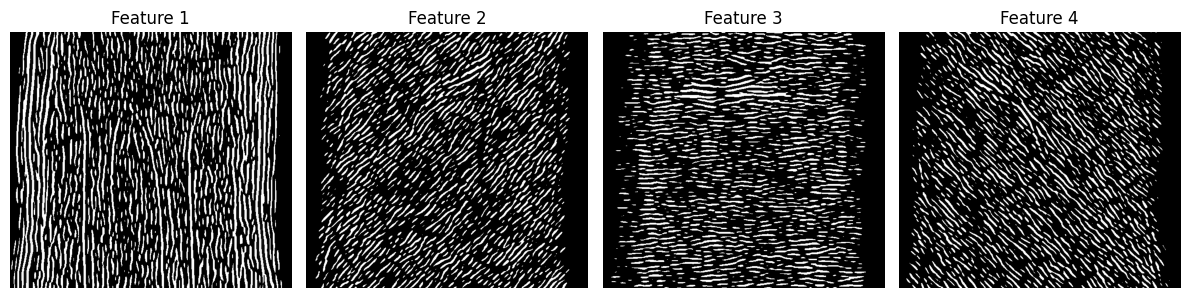

KeyboardInterrupt: 

In [89]:
for idx, image_path in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))):
    image, labels = process_image_and_labels(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp)
    image_gray = image

    # Initialize GaborDescriptor
    gabor_descriptor = GaborDescriptor()

    # Apply Gabor filters to the image
    gabor_features = gabor_descriptor(image_gray)

    # Visualize the first few Gabor features
    num_features = min(len(gabor_features), 16)
    num_cols = 4
    num_rows = (num_features + num_cols - 1) // num_cols

    plt.figure(figsize=(12, 12))
    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(gabor_features[i], cmap='gray')
        plt.title(f'Feature {i + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [66]:
### Extract LBP features and export to npy file
mode = 'test'
class_name = 'normal'

features_list = []
labels_list = []

# gabor_descriptor = GaborDescriptor()
gabor_descriptor = GaborDescriptor(use_alexnet=True, normalize=True)

image_files = glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))
### Loop through all images
for idx, image_path in enumerate(image_files):
    print(f"Processing {idx}/{len(image_files)} : {image_path}")
    features, labels = feature_extraction(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, gabor_descriptor, stepSize=stepSize, windowSize=windowSize)
    features_list.extend(features)
    labels_list.extend(labels)

Processing 0/99 : MLDataset/crop_data/images/test/normal/0045_0661159881_01_WRI-L1_M010.png
Processing 1/99 : MLDataset/crop_data/images/test/normal/0073_1210326335_02_WRI-R1_M017.png
Processing 2/99 : MLDataset/crop_data/images/test/normal/0087_0493070693_01_WRI-R2_F003.png
Processing 3/99 : MLDataset/crop_data/images/test/normal/0351_0798024563_01_WRI-R2_M014.png
Processing 4/99 : MLDataset/crop_data/images/test/normal/0669_0764349986_02_WRI-L1_F013.png
Processing 5/99 : MLDataset/crop_data/images/test/normal/0019_0224740760_01_WRI-R1_M009.png
Processing 6/99 : MLDataset/crop_data/images/test/normal/0022_0473957122_03_WRI-R2_M014.png
Processing 7/99 : MLDataset/crop_data/images/test/normal/0073_1156812570_01_WRI-L2_M015.png
Processing 8/99 : MLDataset/crop_data/images/test/normal/0074_0778270458_01_WRI-L1_F010.png
Processing 9/99 : MLDataset/crop_data/images/test/normal/0023_0657842010_02_WRI-L2_M012.png
Processing 10/99 : MLDataset/crop_data/images/test/normal/0386_0704200329_01_WRI

In [67]:
name = mode + '_' + class_name
export_features(export_path=root_path, name=name, feature_name='gabor', feature_list=features_list)
export_features(export_path=root_path, name=name, feature_name='labels', feature_list=labels_list)

Save gabor features to MLDataset/crop_data/test_normal_gabor.npy
Save labels features to MLDataset/crop_data/test_normal_labels.npy


1


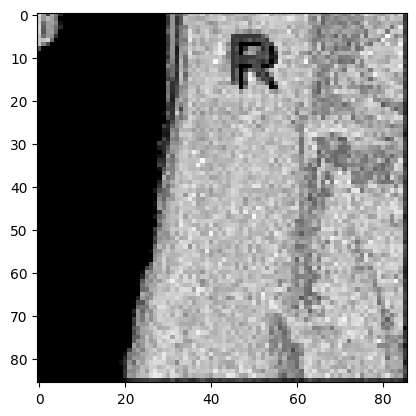

0


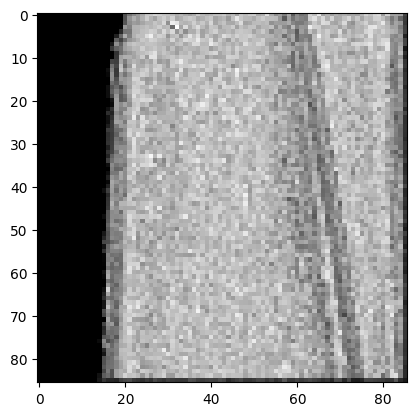

0


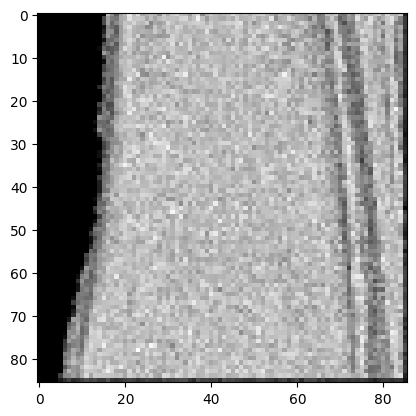

1


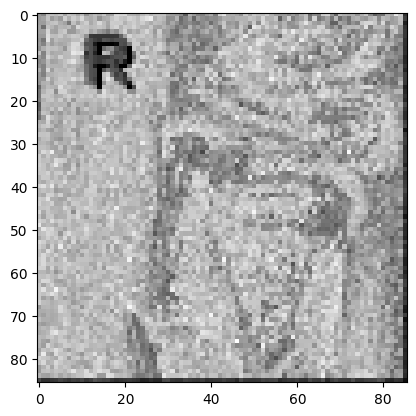

-1


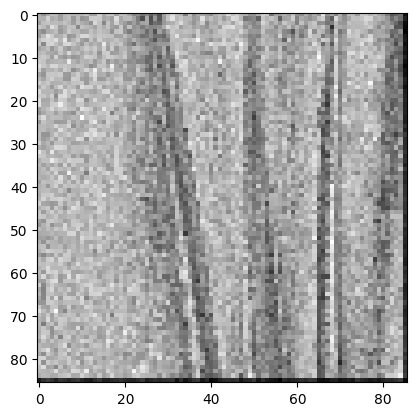

0


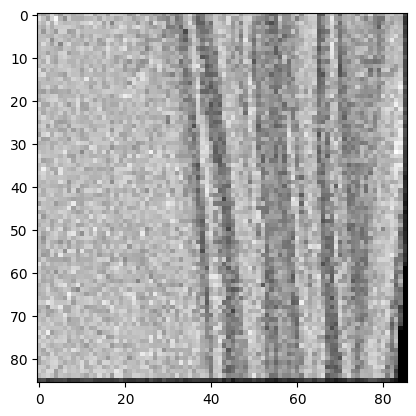

1


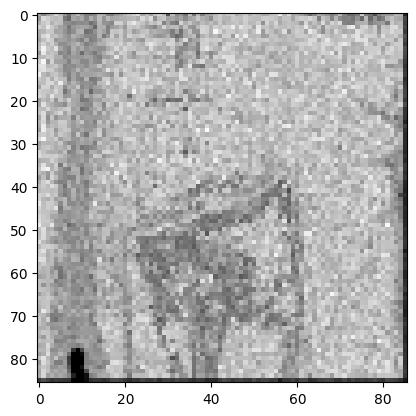

0


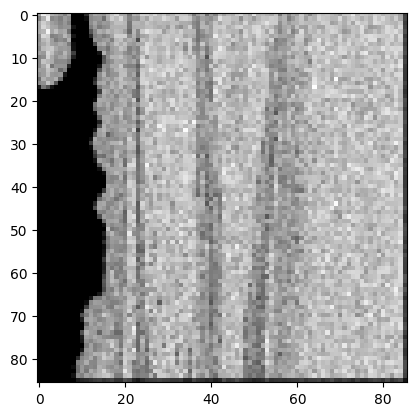

1


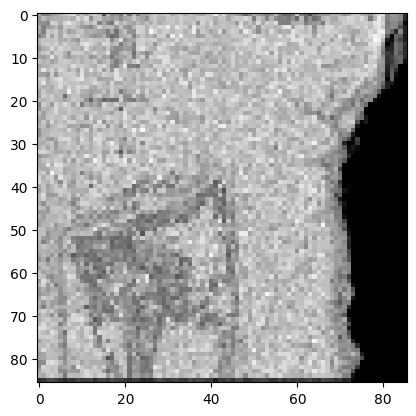

0


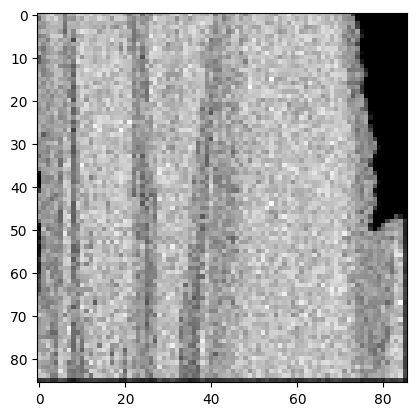

-1


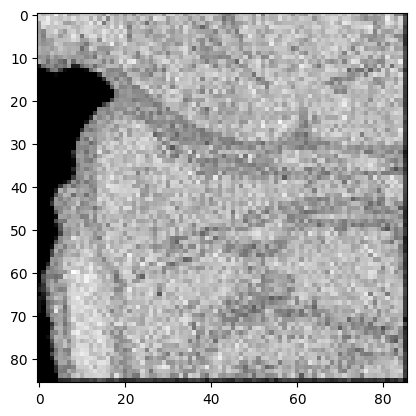

1


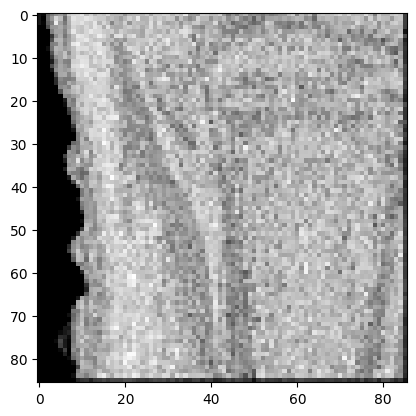

-1


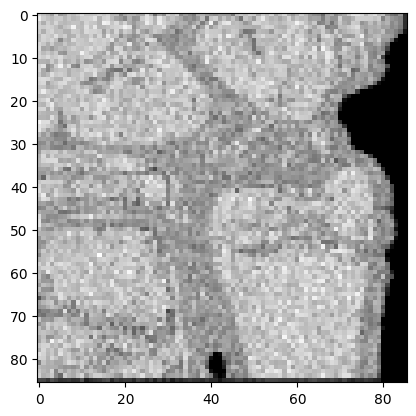

-1


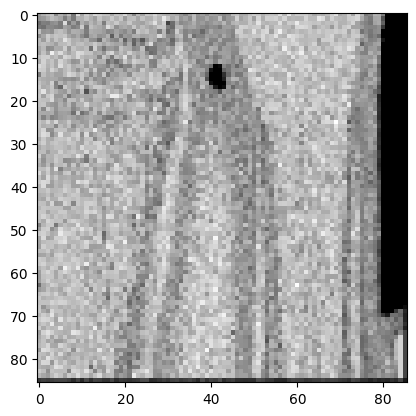

1


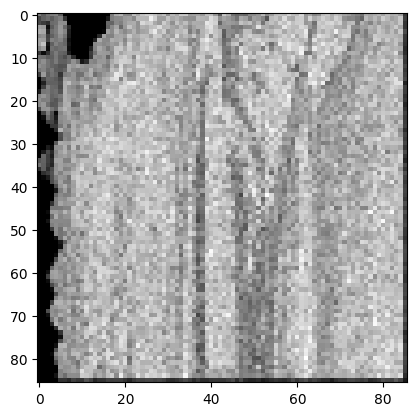

0


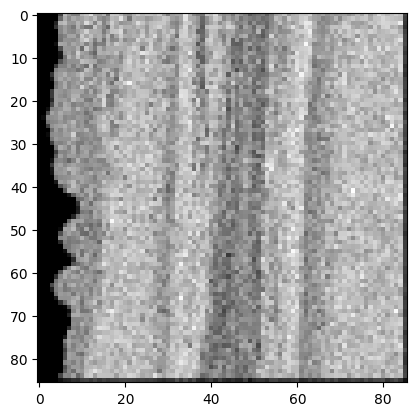

0


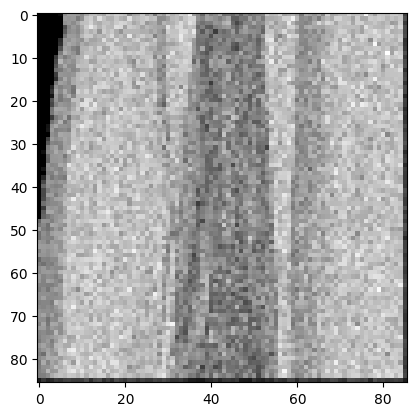

0


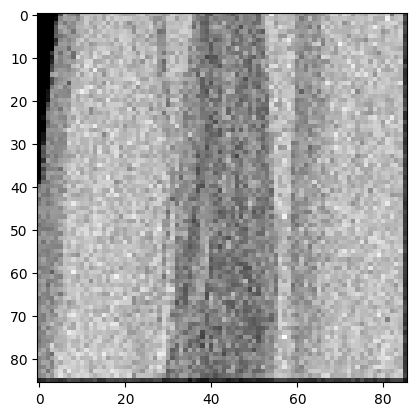

1


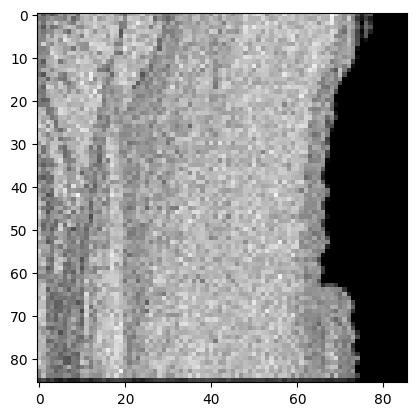

0


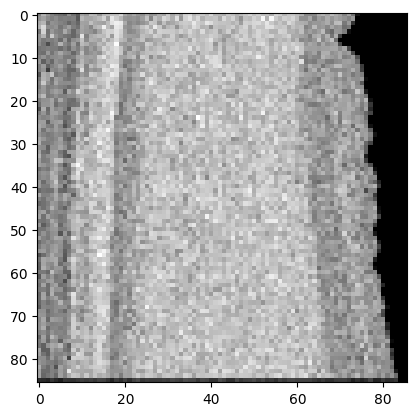

In [90]:
for i in range(20):
    print(labels_list[i])
    plt.imshow(features_list[i].reshape(86,86), cmap='gray')
    plt.show()

## Machine Learning Model

### Load data

In [11]:
dataset_path = 'MLDataset/crop_data'

In [131]:
# Load the dictionary from the .npz file
train_fracture = np.load(os.path.join(root_path, 'train_fracture_gabor.npy'), allow_pickle=True)
train_normal = np.load(os.path.join(root_path, 'train_normal_gabor.npy'), allow_pickle=True)
train_fracture_labels = np.load(os.path.join(root_path, 'train_fracture_labels.npy'), allow_pickle=True)
train_normal_labels = np.load(os.path.join(root_path, 'train_normal_labels.npy'), allow_pickle=True)

test_fracture = np.load(os.path.join(root_path, 'test_fracture_gabor.npy'), allow_pickle=True)
test_normal = np.load(os.path.join(root_path, 'test_normal_gabor.npy'), allow_pickle=True)
test_fracture_labels = np.load(os.path.join(root_path, 'test_fracture_labels.npy'), allow_pickle=True)
test_normal_labels = np.load(os.path.join(root_path, 'test_normal_labels.npy'), allow_pickle=True)

train_features_gb = np.concatenate([train_fracture, train_normal])
train_labels_gb = np.concatenate([train_fracture_labels, train_normal_labels])
train_indices = np.where(train_labels_gb != -1)[0]
train_features_gb = train_features_gb[train_indices]
train_labels_gb = train_labels_gb[train_indices]

test_features_gb = np.concatenate([test_fracture, test_normal])
test_labels_gb = np.concatenate([test_fracture_labels, test_normal_labels])
test_indices = np.where(test_labels_gb != -1)[0]
test_features_gb = test_features_gb[test_indices]
test_labels_gb = test_labels_gb[test_indices]

In [133]:
np.unique(test_labels_gb, return_counts=True), np.unique(train_labels_gb, return_counts=True)

((array([0, 1]), array([1822,  453])), (array([0, 1]), array([5056, 1580])))

In [130]:
# Load the dictionary from the .npz file
train_fracture = np.load(os.path.join(root_path, 'train_fracture_lbp.npy'), allow_pickle=True)
train_normal = np.load(os.path.join(root_path, 'train_normal_lbp.npy'), allow_pickle=True)
train_fracture_labels = np.load(os.path.join(root_path, 'train_fracture_labels_lbp.npy'), allow_pickle=True)
train_normal_labels = np.load(os.path.join(root_path, 'train_normal_labels_lbp.npy'), allow_pickle=True)

test_fracture = np.load(os.path.join(root_path, 'test_fracture_lbp.npy'), allow_pickle=True)
test_normal = np.load(os.path.join(root_path, 'test_normal_lbp.npy'), allow_pickle=True)
test_fracture_labels = np.load(os.path.join(root_path, 'test_fracture_labels_lbp.npy'), allow_pickle=True)
test_normal_labels = np.load(os.path.join(root_path, 'test_normal_labels_lbp.npy'), allow_pickle=True)

train_features_lbp = np.concatenate([train_fracture, train_normal])
train_labels_lbp = np.concatenate([train_fracture_labels, train_normal_labels])
train_indices = np.where(train_labels_lbp != -1)[0]
train_features_lbp = train_features_lbp[train_indices]
train_labels_lbp = train_labels_lbp[train_indices]

test_features_lbp = np.concatenate([test_fracture, test_normal])
test_labels_lbp = np.concatenate([test_fracture_labels, test_normal_labels])
test_indices = np.where(test_labels_lbp != -1)[0]
test_features_lbp = test_features_lbp[test_indices]
test_labels_lbp = test_labels_lbp[test_indices]

In [134]:
np.unique(test_labels_lbp, return_counts=True), np.unique(train_labels_lbp, return_counts=True)

((array([0, 1]), array([1822,  453])), (array([0, 1]), array([5056, 1580])))

In [4]:
# Load the dictionary from the .npz file
train_fracture = np.load(os.path.join(root_path, 'train_fracture_hog.npy'), allow_pickle=True)
train_normal = np.load(os.path.join(root_path, 'train_normal_hog.npy'), allow_pickle=True)
train_fracture_labels = np.load(os.path.join(root_path, 'train_fracture_labels.npy'), allow_pickle=True)
train_normal_labels = np.load(os.path.join(root_path, 'train_normal_labels.npy'), allow_pickle=True)

train_features_hog = np.concatenate([train_fracture, train_normal])
train_labels_hog = np.concatenate([train_fracture_labels, train_normal_labels])
train_indices = np.where(train_labels_hog != -1)[0]
train_features_hog = train_features_hog[train_indices]
train_labels_hog = train_labels_hog[train_indices]

# test_fracture = np.load(os.path.join(root_path, 'test_fracture_hog.npy'), allow_pickle=True)
# test_normal = np.load(os.path.join(root_path, 'test_normal_hog.npy'), allow_pickle=True)
# test_fracture_labels = np.load(os.path.join(root_path, 'test_fracture_labels.npy'), allow_pickle=True)
# test_normal_labels = np.load(os.path.join(root_path, 'test_normal_labels.npy'), allow_pickle=True)

# test_features_hog = np.concatenate([test_fracture, test_normal])
# test_labels_hog = np.concatenate([test_fracture_labels, test_normal_labels])
# test_indices = np.where(test_labels_hog != -1)[0]
# test_features_hog = test_features_hog[test_indices]
# test_labels_hog = test_labels_gb[test_indices]

IndexError: index 1206 is out of bounds for axis 0 with size 1206

In [7]:
train_features_hog.shape, train_labels_hog.shape
# ((array([0, 1]), array([1822,  453])), (array([0, 1]), array([5056, 1580])))


((1206, 1606500), (7314,))

In [145]:
train_features = np.concatenate([train_features_gb, train_features_lbp], axis=1)
train_labels = train_labels_lbp

test_features = np.concatenate([test_features_gb, test_features_lbp], axis=1)
test_labels = test_labels_lbp

In [146]:
import random
random.shuffle(list(range(len(train_features))))

# test_features = test_features
# test_labels = test_labels

### Resample data

In [147]:
# Split the dataset into majority and minority classes
X_majority = train_features[train_labels == 0]
y_majority = train_labels[train_labels == 0]
X_minority = train_features[train_labels == 1]
y_minority = train_labels[train_labels == 1]

# Downsample the majority class
X_majority_downsampled, y_majority_downsampled = resample(X_majority,
                                                        y_majority,
                                                        replace=False,
                                                        n_samples=len(y_minority),
                                                        random_state=42)

# Combine the downsampled majority class with the minority class
X_balanced = np.vstack((X_majority_downsampled, X_minority))
y_balanced = np.hstack((y_majority_downsampled, y_minority))

In [148]:
np.unique(y_balanced, return_counts=True)

(array([0, 1]), array([1580, 1580]))

In [149]:
# X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42, stratify=train_labels)
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

### Training

In [85]:
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [150]:
# model = SVC()
model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')
# model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.05, num_class=2, objective='multi:softmax')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=50,
                       random_state=42)

In [151]:
# Evaluate the model on the valid set
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print('f1-score:', f1_score(y_val, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.52      0.53      0.52       316
           1       0.52      0.52      0.52       316

    accuracy                           0.52       632
   macro avg       0.52      0.52      0.52       632
weighted avg       0.52      0.52      0.52       632

[[166 150]
 [151 165]]
f1-score: 0.5237329848306181


## Export the model

In [113]:
model_path = 'models/weights/svm_gabor.pkl'

In [97]:
### Export model
joblib.dump(model, model_path)

['models/weights/svm_gabor.pkl']

## Load the model

In [114]:
model = joblib.load(model_path)

## Testing

In [13]:
test_normal_features = np.load(os.path.join(dataset_path, 'test_normal_lbp.npy'))
test_non_fracture = np.load(os.path.join(dataset_path, 'test_non_fracture_lbp.npy'))
test_non_fracture_features = np.concatenate([test_normal_features, test_non_fracture])

test_fracture_features = np.load(os.path.join(dataset_path, 'test_fracture_lbp.npy'))
test_features = np.concatenate([test_non_fracture_features, test_fracture_features])
test_labels = np.array([0] * len(test_non_fracture_features) + [1] * len(test_fracture_features))

: 

In [6]:
test_features_npy = ['test_normal_lbp.npy', 'test_non_fracture_lbp.npy', 'test_fracture_lbp.npy']
classes = [0, 0, 1]

In [7]:
save_path = 'results'

for i, npy_file in enumerate(test_features_npy):
    test_features = np.load(os.path.join(dataset_path, npy_file))
    y_pred = model.predict(test_features)
    y_true = np.array([classes[i]] * len(test_features))
    result = np.vstack([y_true, y_pred])
    np.save(os.path.join(save_path, npy_file), result)
    print(f"Saved {npy_file}")

In [8]:
y_pred = []
y_true = []

for r_path in glob.glob(os.path.join(save_path, '*.npy')):
    result = np.load(r_path)
    y_true.extend(result[0,:].tolist())
    y_pred.extend(result[1,:].tolist())

In [103]:
# Evaluate the model on the valid set
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print('f1-score:', f1_score(y_true, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.84      0.57      0.68      1822
           1       0.24      0.56      0.34       453

    accuracy                           0.57      2275
   macro avg       0.54      0.56      0.51      2275
weighted avg       0.72      0.57      0.61      2275

[[1040  782]
 [ 200  253]]
f1-score: 0.6117446493373043


In [152]:
y_true = test_labels
y_pred = model.predict(test_features)

# Evaluate the model on the valid set
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print('f1-score:', f1_score(y_true, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.84      0.57      0.68      1822
           1       0.24      0.55      0.33       453

    accuracy                           0.57      2275
   macro avg       0.54      0.56      0.51      2275
weighted avg       0.72      0.57      0.61      2275

[[1047  775]
 [ 206  247]]
f1-score: 0.6120677675363083


In [117]:
from utils.metrics import calculate_sensitivity
print('Sensitivity:', calculate_sensitivity(y_true, y_pred))

Sensitivity: 0.8543046357615894


(-0.5, 999.5, 999.5, -0.5)

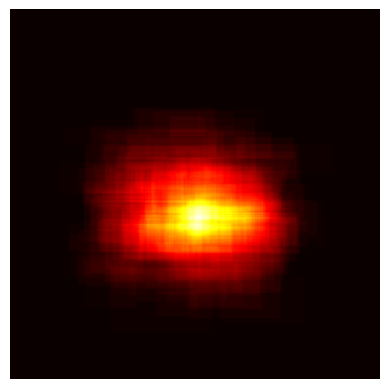

In [13]:
heatmap = np.load('./heatmap.npy')
coords = np.column_stack(np.where(heatmap > 0))
top_left = coords.min(axis=0)
bottom_right = coords.max(axis=0)
plt.imshow(heatmap, cmap='hot')
plt.axis('off')

In [20]:
from utils.vis import draw_bboxes

image_files = glob.glob(os.path.join(root_path, 'test/**/*.png'), recursive=True)

## Apply histogram matching for each image
for i, image_file in enumerate(image_files):
    if 'fracture' not in image_file:
        continue
    print(f"Processing {image_file}")
    ### Parse label
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image_name = os.path.basename(image_file)
    label_path = os.path.join(root_path, label_folder, image_name.replace('.png', '.txt'))
    labels = load_yolo_labels(label_path, image.shape, [3]) # 3 is the class index for fracture 
    draw_bboxes(image, labels)
    
    scaled_roi_coords = [top_left[0]/heatmap.shape[0]*image.shape[0], top_left[1]/heatmap.shape[1]*image.shape[1], bottom_right[0]/heatmap.shape[0]*image.shape[0], bottom_right[1]/heatmap.shape[1]*image.shape[1]]
    roi_image = image[int(scaled_roi_coords[0]):int(scaled_roi_coords[2]), int(scaled_roi_coords[1]):int(scaled_roi_coords[3])]

    _, fig = plt.subplots(1, 2, figsize=(10, 5))
    fig[0].imshow(image, cmap='gray')
    fig[0].axis('off')
    fig[1].imshow(roi_image, cmap='gray')
    fig[1].axis('off')
    
    plt.show()

In [17]:
from utils.vis import draw_bboxes

crop_data_path = os.path.join(root_path, 'crop_data/images')
mode = 'train'
save_path = os.path.join(crop_data_path, mode)

image_files = glob.glob(os.path.join(root_path, image_folder, mode, '**/*.png'), recursive=True)


## Apply histogram matching for each image
for i, image_file in enumerate(image_files):
    print(f"Processing {image_file}")
    ### Parse label
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image_name = os.path.basename(image_file)
    
    scaled_roi_coords = [top_left[0]/heatmap.shape[0]*image.shape[0], top_left[1]/heatmap.shape[1]*image.shape[1], bottom_right[0]/heatmap.shape[0]*image.shape[0], bottom_right[1]/heatmap.shape[1]*image.shape[1]]
    roi_image = image[int(scaled_roi_coords[0]):int(scaled_roi_coords[2]), int(scaled_roi_coords[1]):int(scaled_roi_coords[3])]
    
    ## Save the cropped image
    class_name = image_file.split('/')[-2]
    os.makedirs(os.path.join(save_path, class_name), exist_ok=True)
    cv2.imwrite(os.path.join(os.path.join(save_path, class_name), image_name), roi_image)
    
    if 'normal' in image_file:
        continue
    label_path = image_file.replace('images', 'labels').replace('.png', '.txt')
    labels = load_yolo_labels(label_path, image.shape, [3]) # 3 is the class index for fracture 
    ## Rescale the labels to cropped image
    new_labels = []
    for label in labels:
        c, *xyxy = label
        x1, y1, x2, y2 = xyxy
        roi_x1, roi_y1, roi_x2, roi_y2 = x1-scaled_roi_coords[1], y1-scaled_roi_coords[0], x2-scaled_roi_coords[1], y2-scaled_roi_coords[0]
        # new_labels.append([c, roi_x1, roi_y1, roi_x2, roi_y2])
        roi_h, roi_w = roi_image.shape
        norm_x1, norm_y1, norm_x2, norm_y2 = roi_x1/roi_w, roi_y1/roi_h, roi_x2/roi_w, roi_y2/roi_h
        norm_xc, norm_yc = (norm_x1 + norm_x2)/2, (norm_y1 + norm_y2)/2
        norm_w, norm_h = norm_x2 - norm_x1, norm_y2 - norm_y1
        new_labels.append([c, norm_xc, norm_yc, norm_w, norm_h])
    
    # draw_bboxes(roi_image, new_labels)
    ## Export new labels
    save_label_path = save_path.replace('images', 'labels')
    os.makedirs(os.path.join(save_label_path, class_name), exist_ok=True)
    new_label_path = os.path.join(save_label_path, class_name, image_name.replace('.png', '.txt'))
    f = open(new_label_path, 'w')
    for label in new_labels:
        f.write(f"{label[0]} {label[1]} {label[2]} {label[3]} {label[4]}\n")
    f.close()

    # _, fig = plt.subplots(1, 2, figsize=(10, 5))
    # fig[0].imshow(image, cmap='gray')
    # fig[0].axis('off')
    # fig[1].imshow(roi_image, cmap='gray')
    # fig[1].axis('off')

Processing MLDataset/images/train/normal/0295_0511660026_01_WRI-L1_F015.png
Processing MLDataset/images/train/normal/0159_1276861687_01_WRI-L1_M013.png
Processing MLDataset/images/train/normal/0251_0732110286_01_WRI-L2_M010.png
Processing MLDataset/images/train/normal/0114_0838457189_01_WRI-L1_F010.png
Processing MLDataset/images/train/normal/0154_1139950395_03_WRI-R1_M011.png
Processing MLDataset/images/train/normal/0188_0212411736_01_WRI-L1_M012.png
Processing MLDataset/images/train/normal/1778_1324516348_01_WRI-L2_M009.png
Processing MLDataset/images/train/normal/0266_0382651447_01_WRI-R1_F012.png
Processing MLDataset/images/train/normal/1557_0312275546_01_WRI-L1_M011.png
Processing MLDataset/images/train/normal/0161_0809821041_01_WRI-R2_M015.png
Processing MLDataset/images/train/normal/0153_0319273069_01_WRI-R2_M016.png
Processing MLDataset/images/train/normal/1692_0545940912_01_WRI-L1_F010.png
Processing MLDataset/images/train/normal/0118_0296477953_01_WRI-L1_F014.png
Processing M